In [1]:
import SimpleITK as sitk
import os
import h5py
import numpy as np
import matplotlib
import os
import SimpleITK as sitk
import tensorflow as tf
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
data_path = '/media/marsdenlab/Data2/brats/'

In [3]:
data = h5py.File(data_path+'brats_train.h5','r')
data_test = h5py.File(data_path+'brats_test.h5','r')


X_p_train = data['X_positive']
Y_p_train = data['Y_positive']
X_n_train = data['X_negative']
Y_n_train = data['Y_negative']
print np.amax(Y_p_train)
print ("X_p_train shape = {}\n Y_p_train shape = {}\n X_n_train shape = {}\n Y_n_train shape = {}".
format(X_p_train.shape, Y_p_train.shape, X_n_train.shape, Y_n_train.shape))

X_p_test = data_test['X_positive']
Y_p_test = data_test['Y_positive']
X_n_test = data_test['X_negative']
Y_n_test = data_test['Y_negative']

print ("X_p_test shape = {}\n Y_p_test shape = {}\n X_n_test shape = {}\n Y_n_test shape = {}".
format(X_p_test.shape, Y_p_test.shape, X_n_test.shape, Y_n_test.shape))

4.0
X_p_train shape = (14640, 200, 200)
 Y_p_train shape = (14640, 200, 200)
 X_n_train shape = (16360, 200, 200)
 Y_n_train shape = (16360, 200, 200)
X_p_test shape = (1474, 200, 200)
 Y_p_test shape = (1474, 200, 200)
 X_n_test shape = (1626, 200, 200)
 Y_n_test shape = (1626, 200, 200)


In [4]:
def leaky_relu(x):
    return tf.maximum(0.2*x,x)

def conv2D(x, dims=[3, 3], filters=32, strides=[1, 1],
           std=1e-3, padding='SAME', activation=tf.identity, scope='conv2d'):
  """
  args:
      x, (tf tensor), tensor with shape (batch,width,height,channels)
      dims, (list), size of convolution filters
      filters, (int), number of filters used
      strides, (list), number of steps convolutions slide
      std, (float/string), std of weight initialization, 'xavier' for xavier
          initialization
      padding, (string), 'SAME' or 'VALID' determines if input should be padded
          to keep output dimensions the same or not
      activation, (tf function), tensorflow activation function, e.g. tf.nn.relu
      scope, (string), scope under which to store variables
  returns:
      a, (tf tensor), the output of the convolution layer, has size
          (batch, new_width , new_height , filters)
  """
  with tf.variable_scope(scope):
    s = x.get_shape().as_list()

    shape = dims + [s[3], filters]

    if std == 'xavier':
      std = np.sqrt(2.0 / (s[1] * s[2] * s[3]))

    W = tf.Variable(tf.random_normal(shape=shape, stddev=std), name='W')

    b = tf.Variable(tf.ones([filters]) * std, name='b')

    o = tf.nn.convolution(x, W, padding, strides=strides)

    o = o + b

    a = activation(o)

    return a
    
def get_batch(Xp,Yp, Xn, Yn, n=32):
    Np = Xp.shape[0]
    Nn = Xn.shape[0]
    
    inds_p = sorted(np.random.choice(range(Np),size=n, replace=False))
    inds_n = sorted(np.random.choice(range(Nn),size=n, replace=False))
    
    xp = Xp[inds_p,:,:]
    yp = Yp[inds_p,:,:]
    
    xn = Xn[inds_n]
    yn = Yn[inds_n]
    
    x = np.concatenate((xp,xn))
    y = np.concatenate((yp,yn))
    
    x = x[:,:,:,np.newaxis]
    return x,y

In [5]:
train_steps = 10000
Nbatch = 16
print_step = 1000

W = X_p_train.shape[1]
H = W
C = 1

num_layers = 6
filters = 16
dims = [5,5]
strides = [1,1]

act = leaky_relu

std=1e-2
num_classes=4
learning_rate=5e-3
momentum=0.9
class_weights= np.asarray([1.0,50.0,75.0,75.0])
# class_weights = class_weights/np.sum(class_weights)


In [6]:
#Tensorflow graph construction

#construct input place holders
x = tf.placeholder(shape=[None,W,H,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,W,H],dtype=tf.int32)

y_truth = tf.one_hot(y,depth=num_classes,axis=3)
print y_truth
o = conv2D(x,dims=dims,filters=filters,strides=strides,std=std,
           activation=act, scope='conv_1')

for i in range(1,num_layers):
    scope = 'conv_{}'.format(i)
    o = conv2D(o,dims=dims,filters=filters,strides=strides,std=std,
           activation=act, scope=scope)

o = conv2D(o,dims=dims,filters=num_classes,strides=strides,std=std,
           activation=tf.identity, scope='conv_final')

yhat = tf.nn.softmax(o)

l_temp = tf.reduce_mean(-y_truth*tf.log(yhat+1e-5),axis=[0,1,2])
print l_temp
l_temp = l_temp*class_weights
print l_temp
loss = tf.reduce_mean(l_temp)

Tensor("one_hot:0", shape=(?, 200, 200, 4), dtype=float32)
Tensor("Mean:0", shape=(4,), dtype=float32)
Tensor("mul_1:0", shape=(4,), dtype=float32)


In [7]:
#Construct the optimizer and training operations
opt = tf.train.MomentumOptimizer(learning_rate,momentum)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

In [8]:
#Construct the tensorflow session and initialize the graph
sess = tf.Session()
sess.run(init)

In [9]:
#Start the train loop
train_hist = []
val_hist = []

for i in range(train_steps):
    xb,yb = get_batch(X_p_train,Y_p_train,X_p_train,Y_p_train,n=Nbatch)
    l,_=sess.run([loss,train],{x:xb,y:yb})

    if i%print_step == 0:
        xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)
        lval=sess.run(loss,{x:xb,y:yb})
        print "iter: {} Train: {} Val: {}".format(i,l,lval)
        train_hist.append(l)
        val_hist.append(lval)

iter: 0 Train: 0.959558904171 Val: 0.848221302032
iter: 1000 Train: 0.834358334541 Val: 0.477247804403
iter: 2000 Train: 0.350439250469 Val: 0.368396669626
iter: 3000 Train: 0.584687829018 Val: 0.230872482061
iter: 4000 Train: 0.545340120792 Val: 0.308651804924
iter: 5000 Train: 0.464859455824 Val: 0.312083810568
iter: 6000 Train: 0.502421140671 Val: 0.233265280724
iter: 7000 Train: 0.379591286182 Val: 0.417868554592
iter: 8000 Train: 0.376623749733 Val: 0.23284612596
iter: 9000 Train: 0.404250502586 Val: 0.390284955502


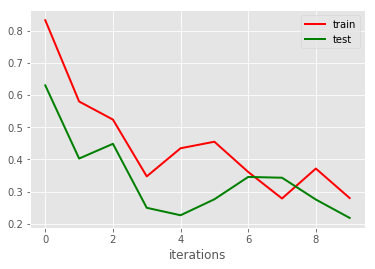

In [12]:
plt.figure()
plt.plot(train_hist,color='r',linewidth=2,label='train')
plt.plot(val_hist,color='g',linewidth=2,label='test')
plt.xlabel('iterations')
plt.legend()
plt.show()

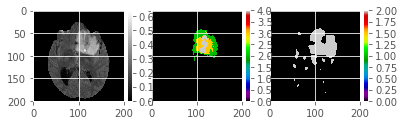

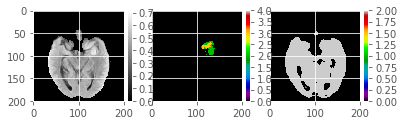

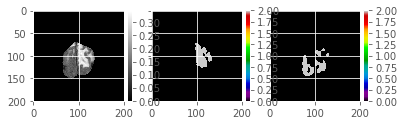

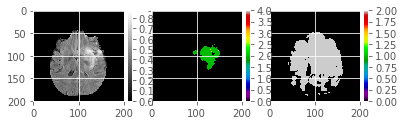

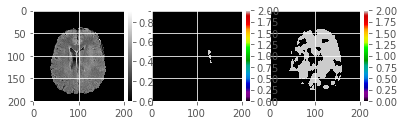

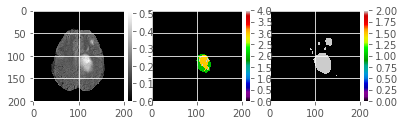

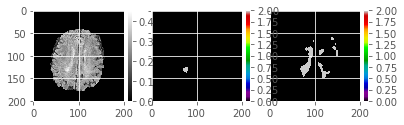

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def implot(mp,ax,cmap='gray'):
    im = ax.imshow(mp.astype(np.float32), cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)

    
xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)

ypred = sess.run(yhat,{x:xb})

ypred = np.argmax(ypred,axis=3)

for i in range(7):

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(xb[i,:,:,0],ax1)
    implot(yb[i,:,:],ax2,cmap='spectral')
    implot(ypred[i,:,:],ax3,cmap='spectral')
    plt.tight_layout
    plt.savefig('images_{}.pdf'.format(i),dpi=600)
    plt.show()